In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.neighbors import NearestNeighbors
from econml.dml import LinearDML
import warnings
import scipy.stats as stats
from tqdm import tqdm

# Suppress warnings for cleaner output (e.g., convergence warnings in high-dim logistic reg)
warnings.filterwarnings('ignore')

## Data generation in rare disease settings

In [2]:
# Data generation function
def generate_rare_disease_data(n=500, p=100, setting='continuous',seed=123):
    np.random.seed(seed)
    
    # 1. Generate Covariates (100 variables)
    X = np.random.normal(0, 1, size=(n, p))
    
    # 2. Define the &quot;True&quot; Confounding Mechanism (The Nuisance Function)
    # Only the first 5 variables (indices 0-4) actually matter.
    # Interaction: X0 * X1
    # Non-linear: X2 squared
    # Linear: X3, X4
    nuisance_term = 0.5 * X[:,0] * X[:,1] + 0.4 * (X[:,2]**2) + 0.3 * X[:,3] + 0.2 * X[:,4]
    # 3. Treatment Assignment (Propensity)
    # P(T=1 | X) depends on the nuisance term
    logit_p = -0.5 + nuisance_term
    prob_t = 1 / (1 + np.exp(-logit_p))
    T = np.random.binomial(1, prob_t)
    TRUE_EFFECT = 1000 # True Causal Effect ($1000)
    
    # Outcome depends on T, the nuisance term (confounding), and noise
    # Note: We scale the nuisance term to ensure confounding is strong enough to bias naive results 
    confounding_effect = 1000 * nuisance_term
    
    Y = 2000 + (TRUE_EFFECT * T) + confounding_effect + np.random.normal(0,
    200, n)
    
    return X, T, Y, TRUE_EFFECT

## Model Setup

In [3]:
class CausalEstimators:

# A helper class to run various causal inference methods:
# 1. Naive (Unadjusted Difference in Means)
# 2. Regression Adjustment (Linear/Logistic)
# 3. IPTW (Inverse Probability of Treatment Weighting)
# 4. PSM (Propensity Score Matching 1:1)
# 5. DML (Double Machine Learning)

    def __init__(self, X, T, Y, outcome_type= 'continuous'):
        self.X = X
        self.T = T
        self.Y = Y
        self.outcome_type = outcome_type
        # Create a DataFrame for easier handling in naive methods
        self.df = pd.DataFrame(X)
        self.df['T'] = T
        self.df['Y'] = Y
    def run_naive(self):
    
        treated = self.df[self.df['T'] == 1]['Y'].mean()
        control = self.df[self.df['T'] == 0]['Y'].mean()
        return treated - control

    def run_regression_adjustment(self):

        # Combine T and X into one feature matrix
        features = np.column_stack((self.T, self.X))
        model = LinearRegression()
        model.fit(features, self.Y)
        # The coefficient of T (index 0) is the additive effect
        return model.coef_[0]

    def run_iptw(self):
        # Estimate Propensity Scores
        ps_model = LogisticRegression(penalty = None,solver='lbfgs', max_iter=2000)
        ps_model.fit(self.X, self.T)
        ps = ps_model.predict_proba(self.X)[:, 1]
        
        # Clip to prevent division by zero or extreme weights
        ps = np.clip(ps, 0.05, 0.95)
        
        # Calculate weights: 1/PS for treated, 1/(1-PS) for control
        weights = np.where(self.T == 1, 1/ps, 1/(1-ps))
        
        # Calculate weighted means for treated and control groups
        treated_mask = (self.T == 1)
        control_mask = (self.T == 0)
        
        weighted_mean_treated = np.average(self.Y[treated_mask], weights=weights[treated_mask])
        weighted_mean_control = np.average(self.Y[control_mask], weights=weights[control_mask])
        
        # Return the Average Treatment Effect (ATE)
        return weighted_mean_treated - weighted_mean_control

    def run_psm(self):
        # Estimate Propensity Scores
        ps_model = LogisticRegression(penalty = None,solver='lbfgs', max_iter=2000)
        ps_model.fit(self.X, self.T)
        ps = ps_model.predict_proba(self.X)[:, 1]
        
        treated_idx = np.where(self.T == 1)[0]
        control_idx = np.where(self.T == 0)[0]
        
        # Safety check for separation
        if len(control_idx) == 0 or len(treated_idx) == 0:
            return np.nan
        
        # Match each treated unit to nearest control unit based on PS
        nbrs = NearestNeighbors(n_neighbors=1).fit(ps[control_idx].reshape(-1, 1))
        distances, indices = nbrs.kneighbors(ps[treated_idx].reshape(-1, 1))
        
        # Apply caliper: discard matches with distance > 0.2 * SD of propensity score
        caliper = 0.2 * np.std(ps)
        valid_matches = distances.flatten() <= caliper
        
        if np.sum(valid_matches) == 0:
            return np.nan
        
        matched_control_idx = control_idx[indices.flatten()[valid_matches]]
        matched_treated_idx = treated_idx[valid_matches]
        
        # Calculate SMD for balance check
        X_treated = self.X[matched_treated_idx]
        X_matched_control = self.X[matched_control_idx]
        
        mean_diff = np.mean(X_treated, axis=0) - np.mean(X_matched_control, axis=0)
        pooled_std = np.sqrt((np.var(X_treated, axis=0) + np.var(X_matched_control, axis=0)) / 2)
        pooled_std = np.where(pooled_std == 0, 1, pooled_std)
        smd = np.abs(mean_diff / pooled_std)
        
        # Return null if more than 10% of variables have poor balance (SMD > 0.25)
        if np.mean(smd > 0.25) > 0.1:
            return np.nan
        
        # Average Treatment Effect on the Treated (ATT)
        return np.mean(self.Y[matched_treated_idx]) - np.mean(self.Y[matched_control_idx])
    
    def run_dml(self):
        # Use shallow trees (depth 2) to prevent overfitting on small N=500
        y_model = GradientBoostingRegressor(n_estimators=200, max_depth=3,
        random_state=42)
        t_model = GradientBoostingClassifier(n_estimators=200, max_depth=3,
        random_state=42)
    
        # Set cv=3 for small sample size (5-fold might be too thin)
        est = LinearDML(model_y=y_model,
                        model_t=t_model,
                        discrete_treatment=True,
                        cv=3,
                        random_state=42)
        est.fit(self.Y, self.T, X=self.X)
        return est.effect(self.X).mean()


## Results summary

In [4]:
def run_simulation(n_epochs=100):
    # 1. Initialize a list to store results
    results_list = []

    print(f"Starting simulation with {n_epochs} epochs...")

    for epoch in tqdm(range(n_epochs)):
        # --- 1. CONTINUOUS OUTCOME ---
        X, T, Y, true_eff = generate_rare_disease_data(n=500, p=100, setting='continuous',seed = epoch)
        sim = CausalEstimators(X, T, Y, outcome_type='continuous')
                
        # 3. Apply your 5 different methods
        # Replace these with your actual function calls (e.g., DML, PSM, etc.)
        
        # Method 1: Naive (Unadjusted)
        res_m1 = sim.run_naive()
        
        # Method 2: Regression (Linear)
        res_m2 = sim.run_regression_adjustment()
        
        # Method 3: IPTW (Logistic PS)
        res_m3 = sim.run_iptw()
        
        # Method 4: PSM (1:1 Nearest Neighbor)
        res_m4 = sim.run_psm()
        
        # Method 5: DML (Gradient Boosting)
        res_m5 = sim.run_dml()

        # 4. Record results for each method in a dictionary
        # We store them as separate rows to make it "tidy" (Long Format)
        methods = {
            "Naive (Unadjusted)": res_m1,
            "Regression (Linear):": res_m2,
            "IPTW (Logistic PS)": res_m3,
            "PSM (1:1 Nearest Neighbor)": res_m4,
            "DML (Gradient Boosting)": res_m5
        }

        for method_name, value in methods.items():
            results_list.append({
                "epoch": epoch,
                "method": method_name,
                "estimate": value,
                "bias": abs(value - true_eff), # You can add metrics here
            })

    # 5. Convert the list of dictionaries to a pandas DataFrame
    df_results = pd.DataFrame(results_list)
    
    return df_results

In [5]:
# Execute 1000 epochs
df = run_simulation(n_epochs=1000)

Starting simulation with 1000 epochs...


100%|██████████| 1000/1000 [2:13:49<00:00,  8.03s/it] 


In [6]:
# Quick summary of mean estimates results across methods for main simulation
# 2. Group and calculate mean, std, and quantiles
summary = df.groupby('method')['estimate'].agg(
    mean='mean',
    std='std',
    ci_2_5=lambda x: x.quantile(0.025),
    ci_97_5=lambda x: x.quantile(0.975)
).reset_index()

# 3. Create a formatted CI column for a cleaner table
summary['95% CI'] = summary.apply(
    lambda x: f"[{x['ci_2_5']:.3f}, {x['ci_97_5']:.3f}]", axis=1
)

print("\nSimulation Estimates Summary:")
print(summary[['method', 'mean', 'std', '95% CI']])


Simulation Estimates Summary:
                       method         mean         std                95% CI
0     DML (Gradient Boosting)  1138.138696   66.683540  [1007.251, 1271.459]
1          IPTW (Logistic PS)  1469.673463   86.489831  [1300.956, 1642.660]
2          Naive (Unadjusted)  1569.734357   73.435230  [1429.200, 1709.107]
3  PSM (1:1 Nearest Neighbor)  1463.250451  107.997305  [1256.173, 1692.049]
4        Regression (Linear):  1463.448216   78.343686  [1309.276, 1618.874]


In [7]:
# Quick summary of mean bias results across methods for main simulation
summary = df.groupby('method')['bias'].agg(
    mean='mean',
    std='std',
    ci_2_5=lambda x: x.quantile(0.025),
    ci_97_5=lambda x: x.quantile(0.975)
).reset_index()

# 3. Create a formatted CI column for a cleaner table
summary['95% CI'] = summary.apply(
    lambda x: f"[{x['ci_2_5']:.3f}, {x['ci_97_5']:.3f}]", axis=1
)

print("\nSimulation Estimates Summary:")
print(summary[['method', 'mean', 'std', '95% CI']])


Simulation Estimates Summary:
                       method        mean         std              95% CI
0     DML (Gradient Boosting)  138.774454   65.348822   [12.191, 271.459]
1          IPTW (Logistic PS)  469.673463   86.489831  [300.956, 642.660]
2          Naive (Unadjusted)  569.734357   73.435230  [429.200, 709.107]
3  PSM (1:1 Nearest Neighbor)  463.250451  107.997305  [256.173, 692.049]
4        Regression (Linear):  463.448216   78.343686  [309.276, 618.874]


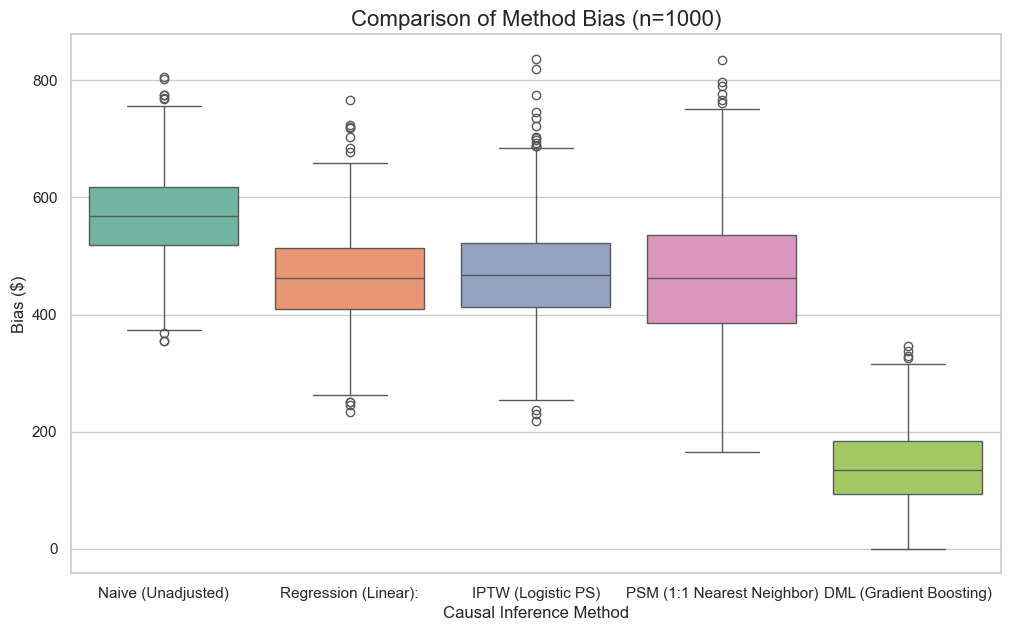

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
# 3. Create the boxplot
plt.figure(figsize=(12, 7))
sns.set_theme(style="whitegrid")

# Optional: Add 'inner="points"' or 'showmeans=True' for more detail
ax = sns.boxplot(x='method', y='bias', data=df, palette='Set2')

# 4. Add formatting
plt.title('Comparison of Method Bias (n=1000)', fontsize=16)
plt.xlabel('Causal Inference Method', fontsize=12)
plt.ylabel('Bias ($)', fontsize=12)
plt.show()